In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt


In [2]:
import warnings
warnings.filterwarnings("ignore")

## Synthetic gene expression generation

In [ ]:
n_cells = 1000
n_genes = 10
p_zero = 0.8 # probability that a gene expression value is zero


rng = np.random.default_rng(seed=32)  # Create a generator with a seed
x_pre = rng.integers(1, 10, size=(n_cells,n_genes))  # Generate 10 random integers between 0 and 10
mask = rng.binomial(n=1, p=1-p_zero, size=(n_cells,n_genes))

x_pre, mask

(array([[8, 2, 8, ..., 3, 6, 7],
        [4, 9, 8, ..., 8, 9, 5],
        [6, 3, 8, ..., 9, 4, 4],
        ...,
        [5, 5, 7, ..., 9, 1, 2],
        [1, 5, 9, ..., 9, 8, 1],
        [2, 7, 7, ..., 8, 6, 9]]),
 array([[0, 0, 1, ..., 0, 1, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 1, ..., 0, 0, 0],
        [1, 0, 0, ..., 1, 0, 0],
        [0, 0, 1, ..., 0, 0, 0]]))

In [4]:
x = x_pre * mask
x

array([[0, 0, 8, ..., 0, 6, 0],
       [0, 9, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 7, ..., 0, 0, 0],
       [1, 0, 0, ..., 9, 0, 0],
       [0, 0, 7, ..., 0, 0, 0]])

## ! Add systematic batch effect on 1/2 of cells


In [5]:
x[:n_cells//2,:] += 10
x *= mask
x

array([[ 0,  0, 18, ...,  0, 16,  0],
       [ 0, 19,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  7, ...,  0,  0,  0],
       [ 1,  0,  0, ...,  9,  0,  0],
       [ 0,  0,  7, ...,  0,  0,  0]])

In [6]:
adata = sc.AnnData(X=x)
adata.obs['batch'] = 0
adata.obs["batch"].iloc[:n_cells//2] = 1
adata.obs["batch"] = adata.obs["batch"].astype("category")
adata

AnnData object with n_obs × n_vars = 1000 × 10
    obs: 'batch'

In [7]:
sc.pp.neighbors(adata)

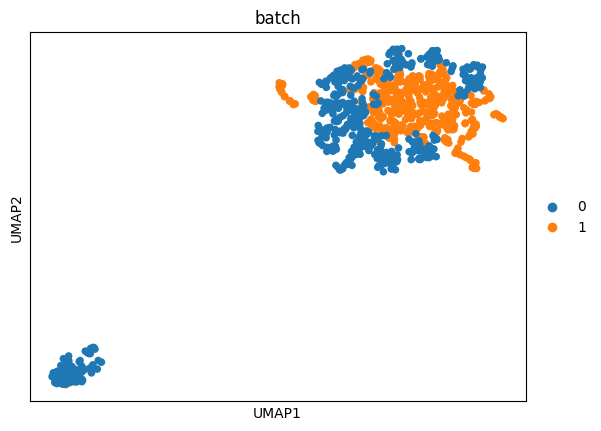

In [8]:
sc.tl.umap(adata)
sc.pl.umap(adata, color='batch')

In [9]:
(adata.X.sum(axis=1) == 0).sum()

np.int64(111)

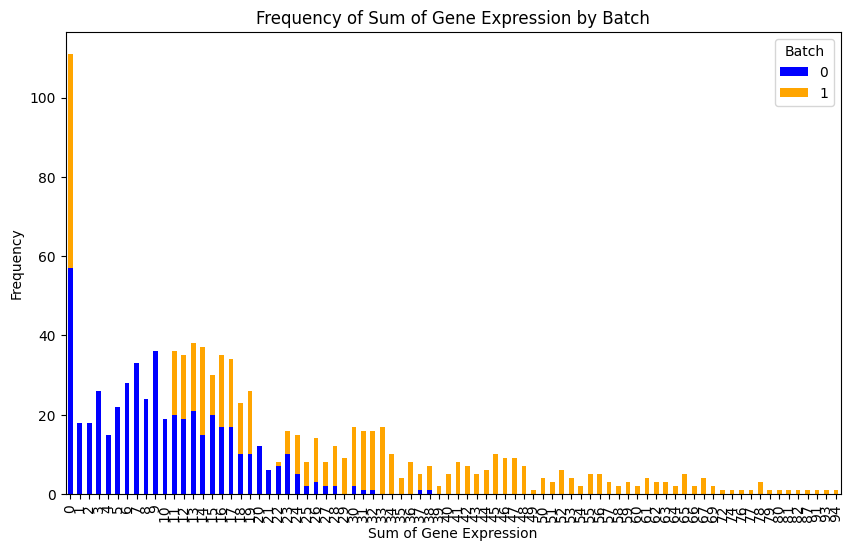

In [10]:
adata.obs["sum_expression"] = adata.X.sum(axis=1)
sum_counts_batch = adata.obs.groupby(["sum_expression", "batch"]).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(10, 6))
colors = ["blue", "orange"]  # Assuming two batches: 0 and 1
sum_counts_batch.plot(kind="bar", stacked=True, color=colors, ax=ax)

ax.set_xlabel("Sum of Gene Expression")
ax.set_ylabel("Frequency")
ax.set_title("Frequency of Sum of Gene Expression by Batch")
plt.legend(title="Batch")
plt.show()

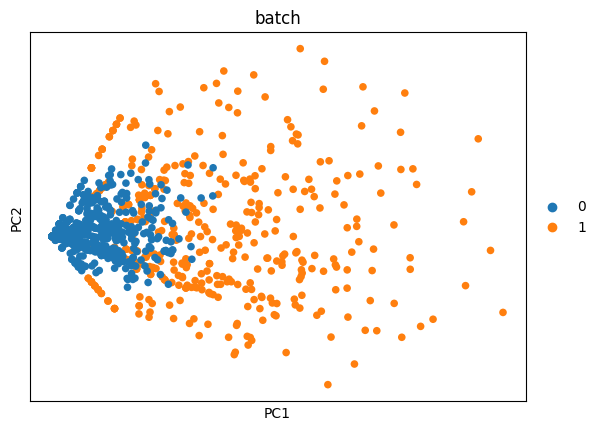

In [11]:
sc.tl.pca(adata)
sc.pl.pca(adata, color='batch')

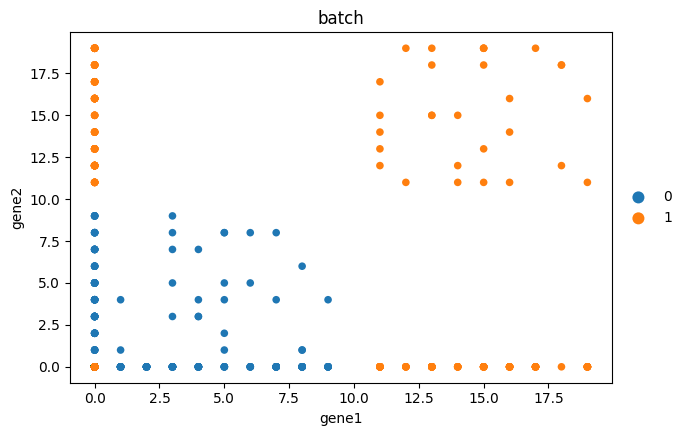

In [12]:
adata.obs["gene1"] = adata.X[:,0]
adata.obs["gene2"] = adata.X[:,1]
sc.pl.scatter(adata, x="gene1", y="gene2", color="batch")

## Architecture and loss definition

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ----------------------------
# ZINB LOSS FUNCTION
# ----------------------------
class ZINBLoss(nn.Module):
    def __init__(self, ridge_lambda=0.0):
        super(ZINBLoss, self).__init__()
        self.eps = 1e-10
        self.ridge_lambda = ridge_lambda

    def forward(self, x, mean, dispersion, pi, scale_factor=1.0):
        x = x.float()
        mean = mean * scale_factor

        nb_case = (
            torch.lgamma(dispersion + self.eps)
            + torch.lgamma(x + 1.0)
            - torch.lgamma(x + dispersion + self.eps)
            - dispersion * torch.log(dispersion + self.eps)
            - x * torch.log(mean + self.eps)
            + (dispersion + x) * torch.log(dispersion + mean + self.eps)
        )

        zero_case = -torch.log(pi + ((1.0 - pi) * torch.exp(-nb_case)) + self.eps)

        result = torch.where(torch.lt(x, 1e-8), zero_case, -torch.log(1.0 - pi + self.eps) + nb_case)
        ridge = self.ridge_lambda * (pi ** 2).sum()

        return result.mean() + ridge


# ----------------------------
# ENCODER
# ----------------------------
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar


# ----------------------------
# DECODER (Conditional on Batch)
# ----------------------------
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, n_batches):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim + n_batches, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, output_dim)
        self.fc_disp = nn.Linear(hidden_dim, output_dim)
        self.fc_pi = nn.Linear(hidden_dim, output_dim)

    def forward(self, z, batch_onehot):
        z_cond = torch.cat([z, batch_onehot], dim=-1)
        h = F.relu(self.fc1(z_cond))
        mean = torch.exp(self.fc_mean(h))
        dispersion = torch.exp(self.fc_disp(h))
        pi = torch.sigmoid(self.fc_pi(h))
        return mean, dispersion, pi


# ----------------------------
# VAE MODULE
# ----------------------------
class ZINBVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, n_batches):
        super(ZINBVAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim, n_batches)
        self.zinb_loss_fn = ZINBLoss()

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, batch_onehot):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        mean, disp, pi = self.decoder(z, batch_onehot)
        return mean, disp, pi, mu, logvar, z

    def loss_function(self, x, mean, disp, pi, mu, logvar):
        zinb_loss = self.zinb_loss_fn(x, mean, disp, pi)
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
        return zinb_loss + kl_div


## Set seed and training loop

No dataloader for simplicity

In [14]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # For deterministic behavior
    #torch.backends.cudnn.deterministic = True
    #torch.backends.cudnn.benchmark = False



In [15]:
adata.obs["batch"]

0      1
1      1
2      1
3      1
4      1
      ..
995    0
996    0
997    0
998    0
999    0
Name: batch, Length: 1000, dtype: category
Categories (2, int64): [0, 1]

In [19]:
# Set the seed
set_seed(11)
vae = ZINBVAE(input_dim=n_genes, hidden_dim=20, latent_dim=5, n_batches=2)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
x = torch.tensor(x, dtype=torch.float32)
batch_onehot = F.one_hot(torch.tensor(adata.obs["batch"], dtype=torch.long), num_classes=2)

vae.train()
for epoch in range(100):
    optimizer.zero_grad()
    mean, disp, pi, mu, logvar, z = vae(x, batch_onehot)
    loss = vae.loss_function(x, mean, disp, pi, mu, logvar)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 5.1813
Epoch 1, Loss: 5.0449
Epoch 2, Loss: 4.9051
Epoch 3, Loss: 4.7717
Epoch 4, Loss: 4.6545
Epoch 5, Loss: 4.5281
Epoch 6, Loss: 4.4224
Epoch 7, Loss: 4.3100
Epoch 8, Loss: 4.2042
Epoch 9, Loss: 4.1201
Epoch 10, Loss: 4.0204
Epoch 11, Loss: 3.9303
Epoch 12, Loss: 3.8536
Epoch 13, Loss: 3.7651
Epoch 14, Loss: 3.6938
Epoch 15, Loss: 3.6272
Epoch 16, Loss: 3.5484
Epoch 17, Loss: 3.4800
Epoch 18, Loss: 3.4154
Epoch 19, Loss: 3.3587
Epoch 20, Loss: 3.2920
Epoch 21, Loss: 3.2348
Epoch 22, Loss: 3.1867
Epoch 23, Loss: 3.1228
Epoch 24, Loss: 3.0731
Epoch 25, Loss: 3.0283
Epoch 26, Loss: 2.9700
Epoch 27, Loss: 2.9244
Epoch 28, Loss: 2.8831
Epoch 29, Loss: 2.8445
Epoch 30, Loss: 2.7978
Epoch 31, Loss: 2.7525
Epoch 32, Loss: 2.7134
Epoch 33, Loss: 2.6766
Epoch 34, Loss: 2.6443
Epoch 35, Loss: 2.6031
Epoch 36, Loss: 2.5746
Epoch 37, Loss: 2.5278
Epoch 38, Loss: 2.4959
Epoch 39, Loss: 2.4709
Epoch 40, Loss: 2.4410
Epoch 41, Loss: 2.4100
Epoch 42, Loss: 2.3925
Epoch 43, Loss: 2.356

In [39]:
adata.obsm["z"] = z.detach().numpy()
adata.obsm["mean"] = mean.detach().numpy()
adata.obsm["dispersion"] = disp.detach().numpy()
adata.obsm["pi"] = pi.detach().numpy()

In [23]:
sc.pp.neighbors(adata, use_rep="z")

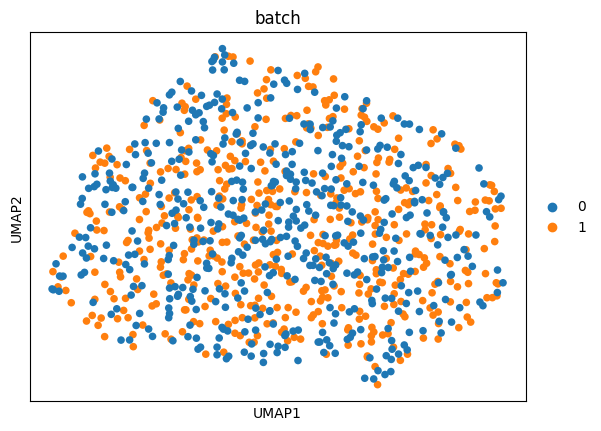

In [24]:
sc.tl.umap(adata)
sc.pl.umap(adata, color='batch')

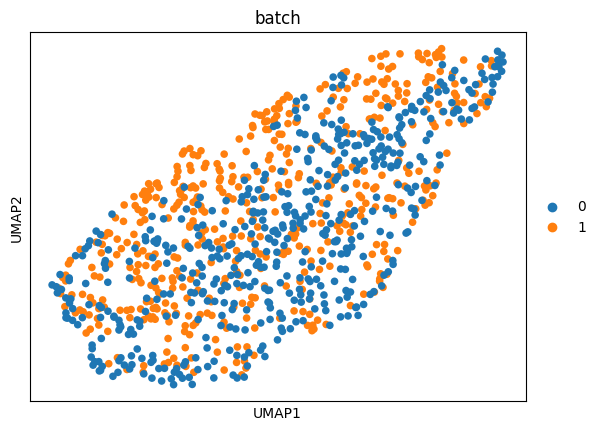

In [40]:
sc.pp.neighbors(adata, use_rep="mean")
sc.tl.umap(adata)
sc.pl.umap(adata, color='batch')

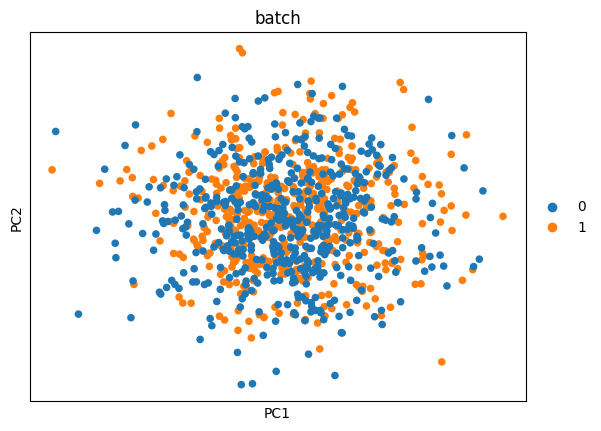

In [27]:
adata_test = sc.AnnData(X=z.detach().numpy())
adata_test.obs["batch"] = adata.obs["batch"]
sc.tl.pca(adata_test)
sc.pl.pca(adata_test, color='batch', layer="z")

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(x.sum(1), label='Input', color='blue', stat='density', kde=True, bins=50, alpha=0.5)
sns.histplot(adata.obsm["mean"].sum(1), label='Decoder Output', color='orange', stat='density', kde=True, bins=50, alpha=0.5)
plt.xlabel("Total Counts per Cell")
plt.ylabel("Density")
plt.title("Distribution of Total Counts per Cell")
plt.legend()
plt.tight_layout()
plt.show()


In [58]:
def sample_zinb(mean, disp, pi, eps=1e-8):
    """
    Sample counts from a Zero-Inflated Negative Binomial distribution.

    Parameters:
        mean: Tensor [n_cells, n_genes]
        disp: Tensor [n_cells, n_genes]
        pi:   Tensor [n_cells, n_genes]

    Returns:
        samples: Tensor [n_cells, n_genes]
    """
    # Ensure tensors are on the same device
    mean, disp, pi = mean.to(torch.float32), disp.to(torch.float32), pi.to(torch.float32)

    # Compute NB parameters
    p = mean / (mean + disp + eps)  # success probability
    r = disp  # number of failures

    # Gamma-Poisson sampling trick for NB
    gamma_sample = torch._standard_gamma(r)
    nb_sample = torch.poisson(gamma_sample * (p / (1 - p + eps)))

    # Apply zero inflation
    keep_mask = torch.bernoulli(1.0 - pi)  # 1 = keep, 0 = zero-inflate
    zinb_sample = nb_sample * keep_mask

    return zinb_sample

set_seed(11)
zinb_sample = sample_zinb(mean, disp, pi)
zinb_sample

tensor([[9., 1., 2.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 4., 0.],
        [0., 0., 0.,  ..., 6., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 2., 5., 0.],
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 1.,  ..., 0., 3., 0.]], grad_fn=<MulBackward0>)

In [60]:
zinb_sample

tensor([[9., 1., 2.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 4., 0.],
        [0., 0., 0.,  ..., 6., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 2., 5., 0.],
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 1.,  ..., 0., 3., 0.]], grad_fn=<MulBackward0>)

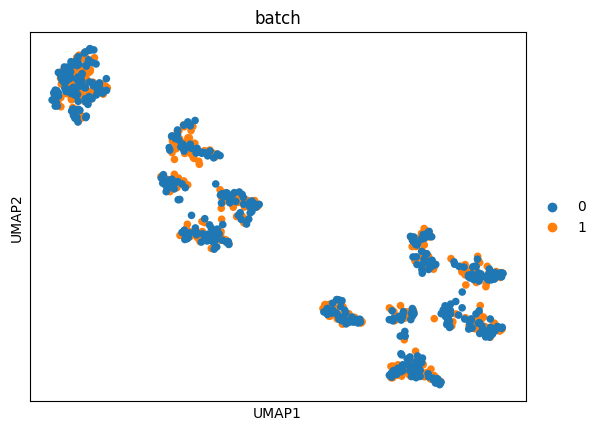

In [66]:
adata.obsm["zinb_sample"] = zinb_sample.detach().numpy()

sc.pp.neighbors(adata, use_rep="zinb_sample")
sc.tl.umap(adata)
sc.pl.umap(adata, color='batch')


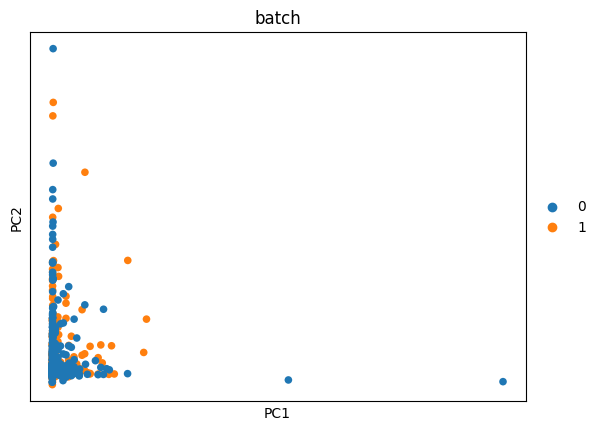

In [63]:
adata_test = sc.AnnData(X=zinb_sample.detach().numpy())
adata_test.obs["batch"] = adata.obs["batch"]
sc.tl.pca(adata_test)
sc.pl.pca(adata_test, color='batch', layer="z")

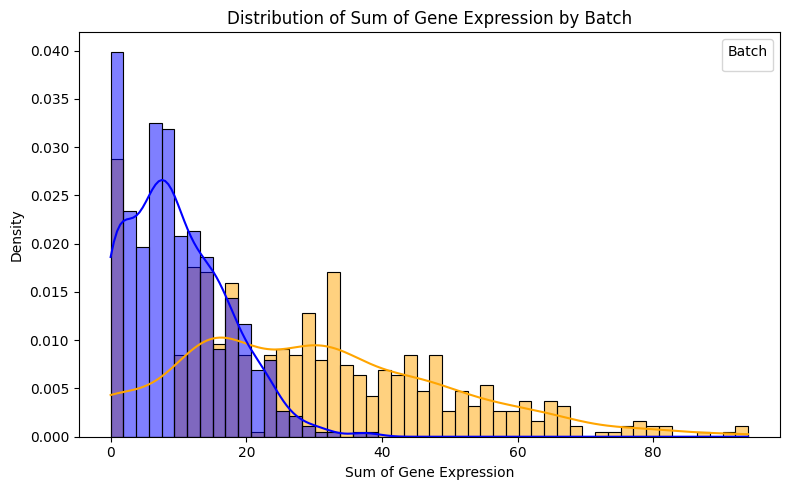

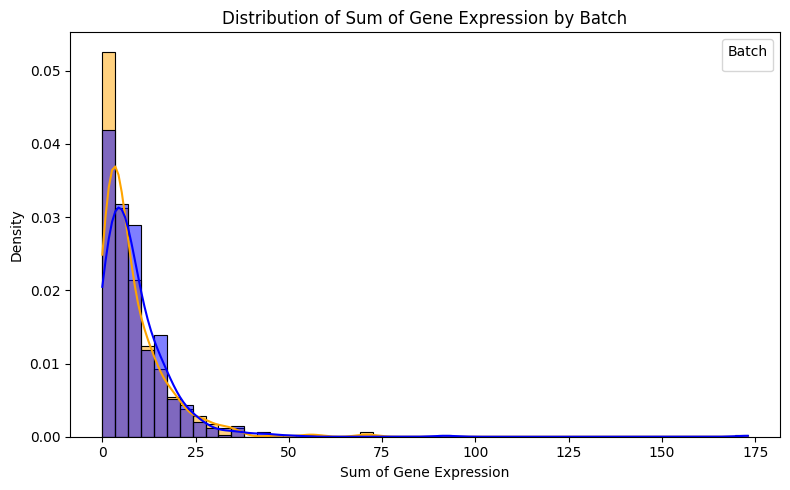

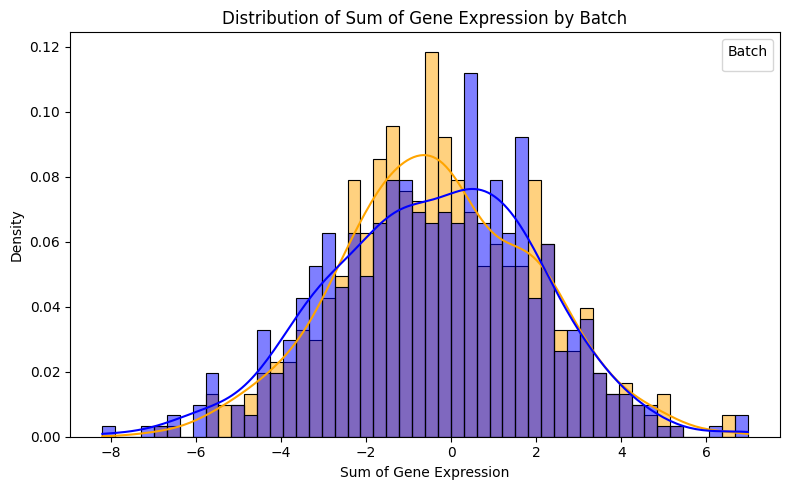

In [64]:
# Convert the sum of gene expression to a pandas DataFrame for plotting
adata.obs["sum_expression"] = adata.X.sum(1)  # Ensure sum_expression is in obs
adata.obs["z"] = adata.obsm["z"].sum(1)
adata.obs["mean"] = adata.obsm["mean"].sum(1)
adata.obs["zinb_sample"] = adata.obsm["zinb_sample"].sum(1)


for key in ["sum_expression", "zinb_sample", "z"]:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=adata.obs, x=key, hue="batch", palette=colors, stat="density", kde=True, bins=50, alpha=0.5)
    plt.xlabel("Sum of Gene Expression")
    plt.ylabel("Density")
    plt.title("Distribution of Sum of Gene Expression by Batch")
    plt.legend(title="Batch")
    plt.tight_layout()
    plt.show()

In [67]:
loss

tensor(1.5767, grad_fn=<AddBackward0>)